## **Exploration 17. Segmentation Map** 

<p align="center"><img src='https://d3s0tskafalll9.cloudfront.net/media/images/p2p_results.max-800x600.png'></p>

### **Table of Contents**

### 1. Introduction
  * 1.1 What is cGAN(Conditional Generative Model)?
  * 1.2 What is Pix2Pix?

### 2. Experiment Environment Set-up
  * 2.1 Load Data
  * 2.2 Import Libraries

### 3. View and Prepare Data
  * 3.1 View Data
  * 3.2 Prepare Data

### 4. Configuring Generators
  * 4.1 Encode Block
  * 4.2 Decode Block
  * 4.3 Encoder + Decoder = Generator

### 5. Reconfiguring the Generator
  * 5.1 U-Net Generator

### 6. Configuring Discriminator
  * 6.1 Discriminator Block
  * 6.2 Discriminator

### 7. Training and Test
  * 7.1 Loss
  * 7.2 Optimizer
  * 7.3 Training
  * 7.4 Results

### 8. Retrospection



---



### 1. Intruduction

### 1.1 What is cGAN(Conditional Generative Model)?

* Original GAN
<p align="center"><img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FsBnfU%2FbtqxgyZP4Zg%2FoVcBshN9TsMLRXeo6RxvD0%2Fimg.png'></p>
<center>[Original GAN 목적함수]</center>

* Conditional GAN
<p align="center"><img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FcaaSop%2Fbtqxf4dvvrH%2FrpvFGiWOchyQFuMKVFgCbk%2Fimg.png'></p>
<center>[Conditional GAN 목적함수]</center>
* GAN에서 input 데이터가 $x$였다면, CGAN에서는 input 데이터가 $x|y$이다. 조건부 데이터를 입력으로 받는다는 이야기이다.
* original GAN에서 input 데이터에 추가정보 $y$라는 조건이 붙는다면($y$를 같이 input한다면) 조건부 생성 모델을 만들 수 있다.
* $y$는 어떤 보조정보라도 될 수 있는데, class label이나 다른 modality의 데이터 등이 될 수 있다.



### 1.2 What is Pix2Pix?

* 기존 노이즈 입력을 이미지로 변환하는 일반적인 GAN이 아니라, 이미지를 입력으로 하여 원하는 다른 형태의 이미지로 변환시킬 수 있는 GAN 모델
* **Image-to-Image Translation**을 수행한다.
* 노이즈와 레이블 정보를 함께 입력했던 cGAN은 fully-connected 레이어를 연속적으로 쌓아 만들었지만, 이미지 변환이 목적인 Pix2Pix는 이미지를 다루는데 효율적인 convolution 레이어를 활용한다.
* GAN 구조를 기반으로 하기 때문에 크게 Generator와 Discriminator 두 가지 구성 요소로 이루어진다.

### 2. Experiment Environment Set-up

### 2.1 Load Data

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving cityscapes.zip to cityscapes.zip


In [ ]:
!unzip /content/cityscapes.zip -d /content/cityscapes/

Archive:  /content/cityscapes.zip
   creating: /content/cityscapes/cityscapes/
   creating: /content/cityscapes/cityscapes/train/
  inflating: /content/cityscapes/cityscapes/train/1.jpg  
  inflating: /content/cityscapes/cityscapes/train/100.jpg  
  inflating: /content/cityscapes/cityscapes/train/1000.jpg  
  inflating: /content/cityscapes/cityscapes/train/101.jpg  
  inflating: /content/cityscapes/cityscapes/train/102.jpg  
  inflating: /content/cityscapes/cityscapes/train/106.jpg  
  inflating: /content/cityscapes/cityscapes/train/109.jpg  
  inflating: /content/cityscapes/cityscapes/train/112.jpg  
  inflating: /content/cityscapes/cityscapes/train/113.jpg  
  inflating: /content/cityscapes/cityscapes/train/114.jpg  
  inflating: /content/cityscapes/cityscapes/train/116.jpg  
  inflating: /content/cityscapes/cityscapes/train/119.jpg  
  inflating: /content/cityscapes/cityscapes/train/12.jpg  
  inflating: /content/cityscapes/cityscapes/train/124.jpg  
  inflating: /content/cityscapes

### 2.2 Import Libraries

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import data
from tensorflow import image
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.preprocessing.image import random_rotation

### 3. Prepare and View Data

### 3.1 View Data 

In [ ]:
data_path = '/content/cityscapes/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


* train data는 총 1000개의 이미지가 있음을 알 수 있다.

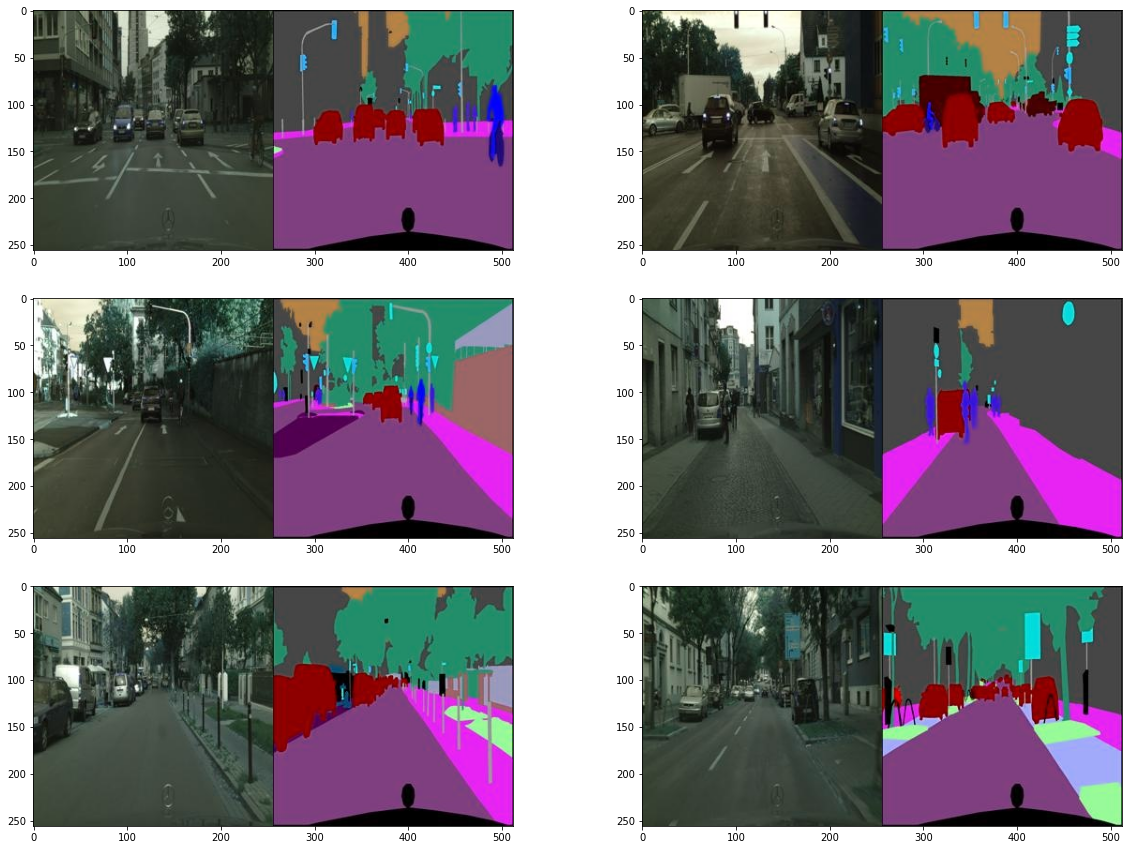

In [ ]:
# 각각의 이미지들이 어떻게 생겼는지 확인해본다.
# 임의로 6장을 선택해 시각화한다.

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(1000)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [ ]:
# 이미지를 하나 열어 크기를 확인해본다.

f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


* 이미지 크기는 (256, 512, 3)으로 확인되었다.
* 모델 학습에 사용할 데이터를 (256, 256, 3) 크기의 2개 이미지로 분할하여 사용한다.

### 3.2 Prepare Data

### 3.2.1 Split Image

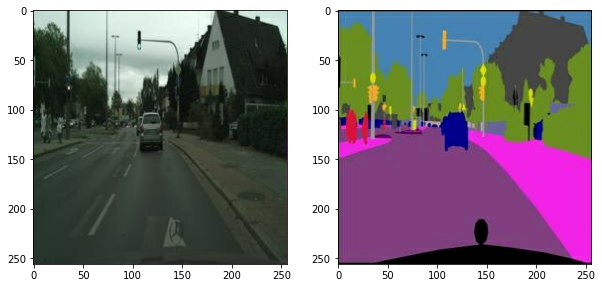

In [ ]:
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

* 하나의 이미지를 두 개 이미지로 나누었다.
* 왼쪽 이미지를 Pix2Pix 모델에 입력하여 두 번째 그림과 같은 채색된 이미지를 생성하는 것이 이번 단계의 목표이다.
* 앞서 살펴봤듯이 학습에 사용할 수 있는 데이터의 수는 1000개뿐이다.
* 학습에 사용하는 데이터의 다양성을 높이기 위해 아래 코드와 같이 여러 augmentation 방법을 적용해본다.


### 3.2.2 Data Augmentation

In [ ]:
@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용한다. 
def apply_augmentation(sketch, colored):  # 원본 및 채색된 2개 이미지를 입력으로 받아 여러 가지 연산을 두 이미지에 동일하게 적용
    # 두 이미지가 채널 축으로 연결된다.
    # 두 이미지가 각각 3채널인 경우 6채널이 된다.
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:  # 합쳐진 이미지에서 50% 확률로 
        # Refection padding 또는
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        # constant padding이 30픽셀의 pad width 만큼적용
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    # (256,256,6) 크기를 가진 이미지를 임의로 잘라낸다.
    out = image.random_crop(padded, size=[256, 256, 6])
    
    # 위에서 잘린 이미지를 50% 확률로 가로로 뒤집는다.
    out = image.random_flip_left_right(out)

    # 위 과정을 거친 결과를 50% 확률로 세로로 뒤집는다.
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        # 위 과정을 거친 겨로가를 50% 확률로 회전시킨다.
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

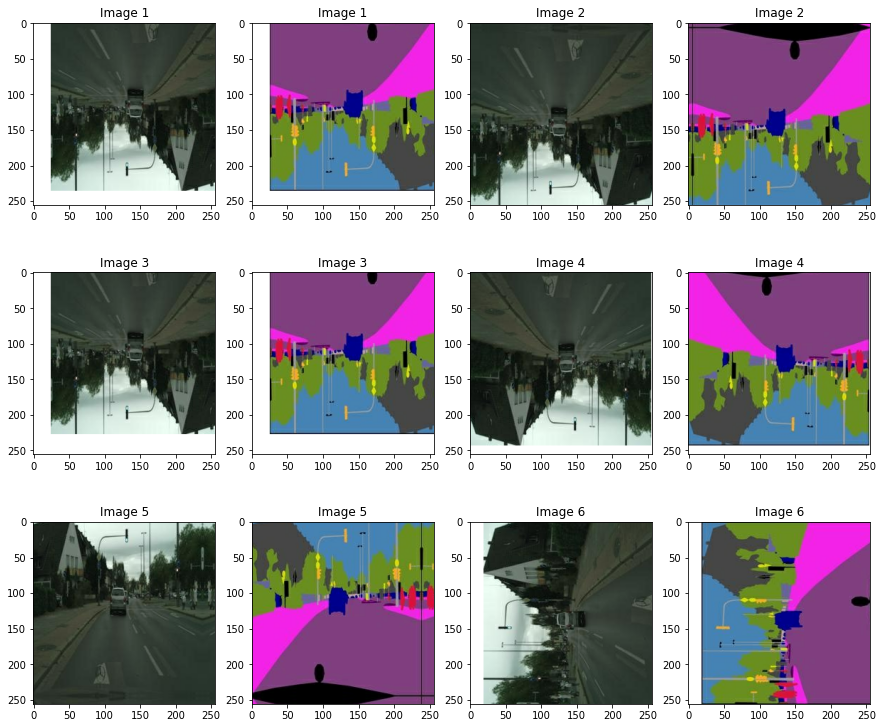

In [ ]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

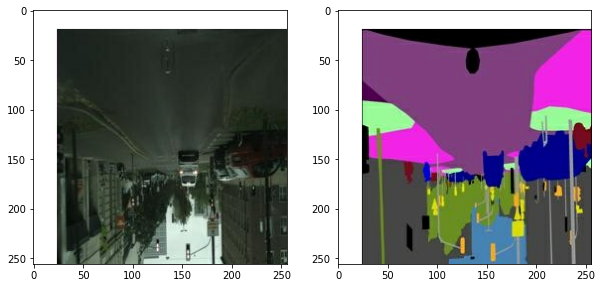

In [ ]:
# 잘 적용되었는지 하나의 이미지만 시각화하여 확인해본다.

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

### 4. Configuring Generators

<p align="center"><img src = 'https://d3s0tskafalll9.cloudfront.net/media/original_images/paper_g.png' height='350'></p>

### 4.1 Encode Block

* 위 논문에서 "C64", "C128" 등으로 쓰여진 것과 같이 "Convolution → BatchNorm → LeakyReLU"의 3개 레이어로 구성된 기본적인 블록을 하나의 레이어로 만든다.

In [ ]:
class EncodeBlock(layers.Layer):
    # n_filters, use_bn를 설정하여 사용할 필터의 개수와 BatchNorm 사용 여부를 결정
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn
        # Convolution layer       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        # BatchNorm layer
        self.batchnorm = layers.BatchNormalization()
        # LeakyRelu
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

In [ ]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        # 각 블록을 거치면서 사용할 필터의 개수를 리스트에 지정
        filters = [64,128,256,512,512,512,512,512]
        
        # blocks에는 사용할 블록들을 정의
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                # Encoder 첫 번째 블록에서는 BatchNorm을 사용하지 않는다.
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    # call() 메서드에서 차례대로 블록들을 통과
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        # 구성한 Encoder에 (256,256,3) 크기의 데이터를 입력했을 때, 어떤 크기의 데이터가 출력되는지 확인
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [ ]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 encode_block (EncodeBlock)  (None, 128, 128, 64)      3072      
                                                                 
 encode_block_1 (EncodeBlock  (None, 64, 64, 128)      131584    
 )                                                               
                                                                 
 encode_block_2 (EncodeBlock  (None, 32, 32, 256)      525312    
 )                                                               
                                                                 
 encode_block_3 (EncodeBlock  (None, 16, 16, 512)      2099200   
 )                                                               
                                                             

* 블록을 통과할수록 (width, height) 크기는 반씩 줄어들고, 사용된 필터의 수는 최대 512개로 늘어나 최종 (1,1,512)로 알맞은 크기가 출력된다.

### 4.2 Decode Block

In [ ]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            # 처음 세 개의 블록에서만 Dropout을 사용
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))

        # 마지막 Convolution에 3개의 필터 사용        
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,512)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [ ]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 1, 512)]       0         
                                                                 
 decode_block (DecodeBlock)  (None, 2, 2, 512)         4196352   
                                                                 
 decode_block_1 (DecodeBlock  (None, 4, 4, 512)        4196352   
 )                                                               
                                                                 
 decode_block_2 (DecodeBlock  (None, 8, 8, 512)        4196352   
 )                                                               
                                                                 
 decode_block_3 (DecodeBlock  (None, 16, 16, 512)      4196352   
 )                                                               
                                                           

* (width, height) 크기가 점점 늘어나고 사용 필터의 수는 점점 줄어들어 최종 (256,256,3) 크기로 알맞게 출력된다.
* 위에서 구성한 Encoder와 Decoder를 연결시키면 Encoder에서 (256,256,3) 입력이 (1,1,512)로 변환되고, Decoder를 통과해 다시 원래 입력 크기와 같은 (256,256,3)의 결과를 얻을 수 있다.

### 4.3 Encoder + Decoder = Generator

In [ ]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 encoder_1 (Encoder)         (None, 1, 1, 512)         19544576  
                                                                 
 decoder_1 (Decoder)         (None, 256, 256, 3)       19542784  
                                                                 
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


### 5. Reconfiguring the Generator

<p align="center"><img src = 'https://d3s0tskafalll9.cloudfront.net/media/images/p2p_result_g2.max-800x600.png' height='300'></p>

In [ ]:
# Encoder 및 Decoder에 사용되는 기본적인 블록은 이전에 아래 코드와 같이 구현했다.
# 특별히 수정해야 할 부분은 없으므로 그대로 가져다가 사용한다.

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

### 5.1 U-Net Generator

In [ ]:
class UNetGenerator(Model):
    def __init__(self):
        # Encoder 및 Decoder에서 사용할 모든 블록들을 정의
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        # call()에서 forward propagation 하도록 한다.
        # __init__() 에서 정의된 encode_blocks 및 decode_blocks가 
        # call() 내부에서 차례대로 사용되어 Encoder 및 Decoder 내부 연산을 수행
        # Encoder와 Decoder 사이의 skip connection을 위해 features 라는 리스트를 만든다.
        features = []
        for block in self.encode_blocks:
            x = block(x)
            # Encoder 내에서 사용된 각 블록들의 출력을 차례대로 담는다.
            features.append(x)
        # features[:-1] : Encoder의 마지막 출력(feature리스트 의 마지막 항목)은 Decoder로 직접 입력되므로 skip connection의 대상이 아니다.
        features = features[:-1]

        # 이후 Encoder의 최종 출력이 Decoder의 입력으로 들어가면서 다시 한번 각각의 Decoder 블록들을 통과   
        # features[::-1] : features에는 Encoder 블록들의 출력들이 순서대로 쌓여있고, 이를 Decoder에서 차례대로 사용하기 위해서 features의 역순으로 연결         
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            # features 리스트에 있는 각각의 출력들이 Decoder 블록 연산 후 함께 연결되어 다음 블록의 입력으로 사용
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [ ]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encode_block_16 (EncodeBlock)  (None, 128, 128, 64  3072        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 encode_block_17 (EncodeBlock)  (None, 64, 64, 128)  131584      ['encode_block_16[0][0]']        
                                                                                            

* Skip connection을 추가한 U-Net Generator의 파라미터는 약 5500만 개로 꽤나 많이 늘어났다.
* U-Net Generator에서 사용한 skip-connection으로 인해 Decoder의 각 블록에서 입력받는 채널 수가 늘어났고, 
* 이에 따라 블록 내 convolution 레이어에서 사용하는 필터 크기가 커지면서 학습해야 할 파라미터가 늘어났다.

### 6. Configuring Discriminator

<p align="center"><img src = 'https://d3s0tskafalll9.cloudfront.net/media/original_images/paper_d.png' height='350'></p>

### 6.1 Discriminator Block

In [ ]:
class DiscBlock(layers.Layer):
    # 필터의 수(n_filters), 필터가 순회하는 간격(stride), 출력 feature map의 크기를 조절할 수 있도록 하는 패딩(custom_pad),
    # BatchNorm의 사용 여부(use_bn), 활성화 함수 사용 여부(act)
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            # padding 레이어 : width 및 height의 양쪽 면에 각각 1씩 패딩되어 총 2만큼 크기가 늘어난다.
            self.padding = layers.ZeroPadding2D()
            # Convolution 레이어
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            # 패딩하지 않고 필터 크기 4 및 간격(stride) 1의 convolution 레이어를 통과하면 width 및 height 가 3씩 줄어든다.
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        # BatchNormalization 레이어
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        # LeakyReLU 활성화 레이어
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        # 이 외 다른 레이어(BatchNorm, LeakyReLU)는 출력의 크기에 영향을 주지 않는다.
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [ ]:
# 간단하게 코드를 작성하여 각 출력의 크기가 맞는지 확인
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 32)]    0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 130, 130, 32)     0         
 2D)                                                             
                                                                 
 conv2d_24 (Conv2D)          (None, 127, 127, 64)      32768     
                                                                 
 batch_normalization_45 (Bat  (None, 127, 127, 64)     256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 127, 127, 64)      0         
                                                                 
Total params: 33,024
Trainable params: 32,896
Non-trainable

* (width, height) 크기를 1씩 감소하는 것을 확인할 수 있다.
* ` ENCODE` 마지막 2개 블록은 출력의 크기가 1씩 감소하므로 이런 방식을 적용하면 된다.

### 6.2 Discriminator

In [ ]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # 첫 번째 블록은 단순한 연결(concat)을 수행
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        # Discriminator의 최종 출력은 sigmoid 활성화를 사용
        self.sigmoid = layers.Activation("sigmoid")
        
        # for loop로 간편하게 블록을 만들 수도 있지만, 
        # 쉽게 코드를 읽게끔 총 6개 블록을 각각 따로 만든다.
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [ ]:
Discriminator().get_summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_7 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_7 (Concatenate)    (None, 256, 256, 6)  0           ['input_6[0][0]',                
                                                                  'input_7[0][0]']          

* 두 개의 (256,256,3) 크기 입력으로 최종 (30,30,1) 출력을 만들었고, 아래의 Discriminator를 나타낸 그림과 각 출력 크기가 일치한다.
<p align="center"><img src='https://d3s0tskafalll9.cloudfront.net/media/images/refer_d.max-800x600.png' height ='100'></p>

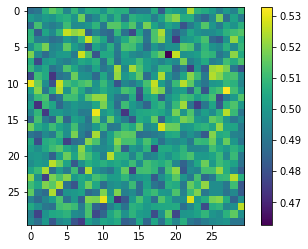

In [ ]:
# 시험 삼아 임의의 (256,256,3) 크기의 입력을 넣어 나오는 (30,30) 출력을 시각화해본다.
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

* 위 (30,30) 크기를 갖는 결과 이미지의 각 픽셀 값은 원래 입력의 (70,70) 패치에 대한 분류 결과이다.
* 전체 입력의 크기가 (256,256) 이므로, 각각의 (70,70) 패치는 원래 입력상에서 많이 겹쳐있을 것이다.
* 각각의 픽셀 값은 `sigmoid` 함수의 결괏값이므로 0~1 사이의 값을 가지며, 진짜 및 가짜 데이터를 판별해 내는 데 사용한다.

### 7. Training and Test

### 7.1 Loss

* 레이블 정보만 있는 입력에 대해 여러 손실 함수를 사용해 실제 이미지를 만들어 낸 결과는, 일반적인 GAN의 손실 함수에 L1을 추가로 이용했을 때 가장 실제에 가까운 이미지를 생성해냈다.
* 여기서도 두 가지 손실 함수를 모두 사용해본다.

In [ ]:
bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

# Generator 손실함수
# fake_disc : Generator가 생성한 가짜 이미지를 Discriminator에 입력하여 얻어진 값
# tf.ones_like() : 실제 이미지를 뜻하는 "1"과 비교하기 위해 사용
# L1 손실을 계산하기 위해 생성한 가짜 이미지(fake_output)와 실제 이미지(real_output) 사이의 MAE 계산
def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

# Discriminator 손실함수
# 2개의 입력값은 가짜 및 진짜 이미지가 Discriminator에 각각 입력되어 얻어진 값
# Discriminator는 실제 이미지를 잘 구분해 내야 하므로 
# real_disc는 "1"로 채워진 벡터와 비교하고, fake_disc는 "0"으로 채워진 벡터와 비교
def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

### 7.2 Optimizer

* 논문과 동일하게 설정한다.

In [ ]:
gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

* 하나의 배치 크기만큼 데이터를 입력했을 때 가중치를 1회 업데이트하는 과정은 아래와 같이 구현
* 최종 Generator 손실을 계산할 때, L1 손실에 100을 곱했다. (## 표시가 있는 부분)
* 논문에서는 Generator의 손실을 아래와 같이 정의했다.

$$
G^* = \arg \min_G \max_D \mathcal{L}_{cGAN}(G,D) + \lambda \mathcal{L}_{L1}(G)
$$

* $\lambda$ : 학습 과정에서 L1 손실을 얼마나 반영할 것인지를 나타내며 논문에서는 $\lambda=100$ 사용

In [ ]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

### 7.3 Training

In [ ]:
EPOCHS = 1000

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
EPOCH[961] - STEP[10]                     
Generator_loss:4.4237                     
L1_loss:0.1102                     
Discriminator_loss:0.0384

EPOCH[961] - STEP[20]                     
Generator_loss:5.3433                     
L1_loss:0.1178                     
Discriminator_loss:0.6602

EPOCH[961] - STEP[30]                     
Generator_loss:5.1673                     
L1_loss:0.1297                     
Discriminator_loss:0.0478

EPOCH[961] - STEP[40]                     
Generator_loss:5.7633                     
L1_loss:0.1137                     
Discriminator_loss:0.0121

EPOCH[961] - STEP[50]                     
Generator_loss:5.2953                     
L1_loss:0.1053                     
Discriminator_loss:0.0303

EPOCH[961] - STEP[60]                     
Generator_loss:5.7846                     
L1_loss:0.1095                     
Discriminator_loss:0.0123

EPOCH[961] - STEP[70]                     
Generator_loss:6.8653      

### 7.4 Results

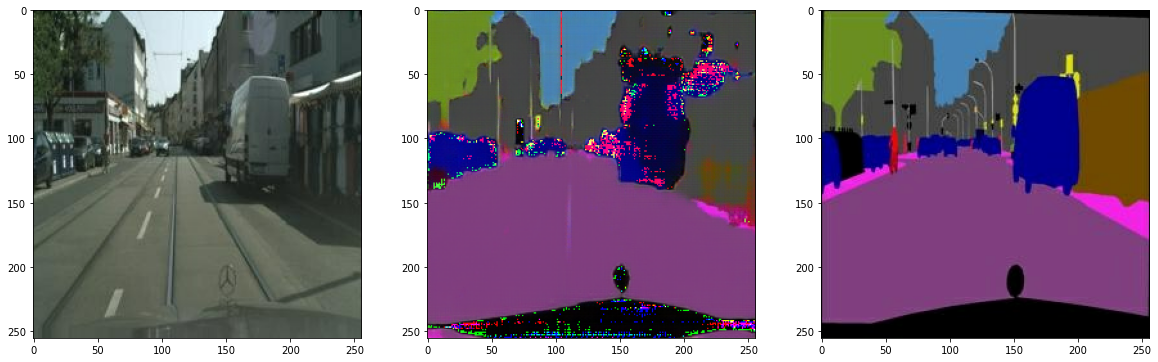

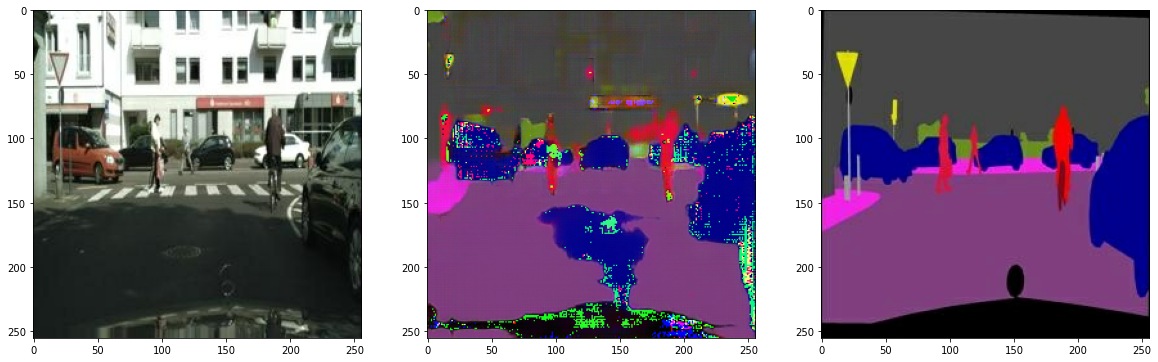

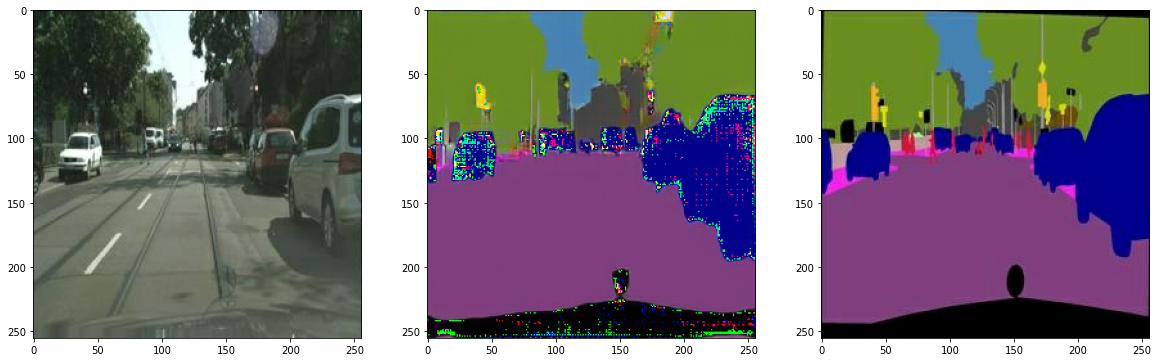

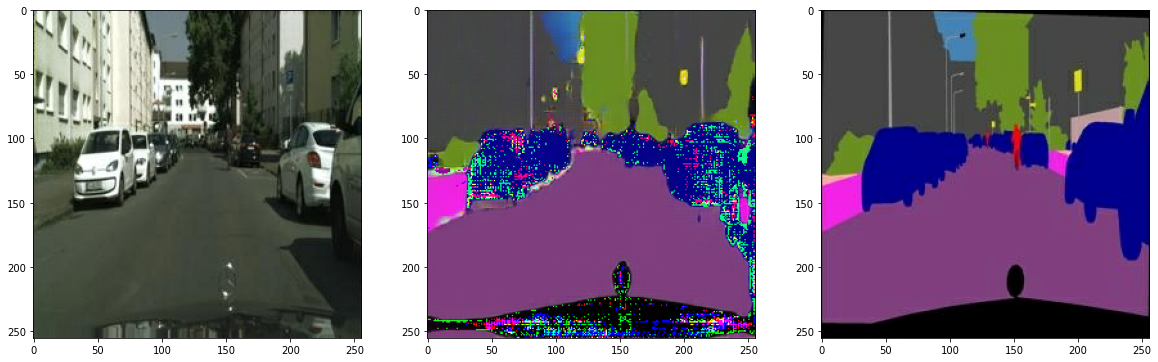

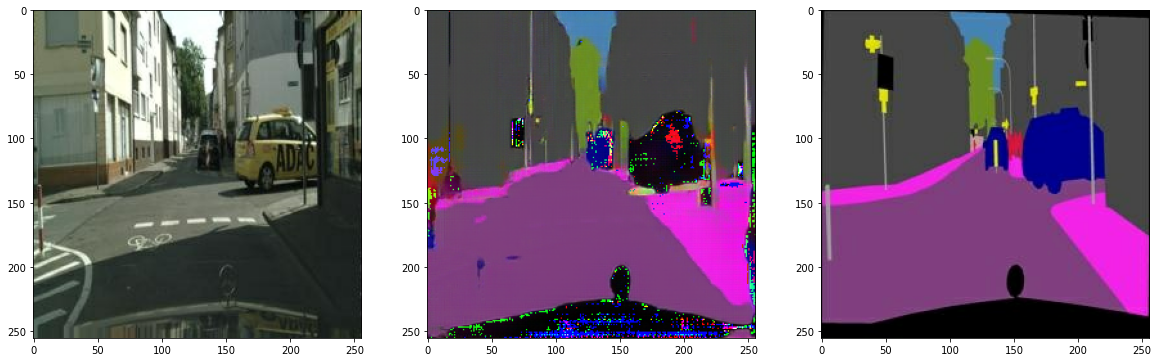

In [ ]:
# 테스트 데이터는 다운로드했던 "val" 폴더 내 이미지를 사용
val_path = '/content/cityscapes/cityscapes/val/'

for i in range(5):

    test_ind = i

    f = val_path + os.listdir(val_path)[test_ind]
    sketch, colored = load_img(f)

    pred = generator(tf.expand_dims(sketch, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
    plt.subplot(1,3,2); plt.imshow(pred[0])
    plt.subplot(1,3,3); plt.imshow(denormalize(colored))

* 1000epoch로 학습한 뒤, val data로 이미지를 확인해보았다.
* 제대로 색칠이 되지 않은 부분들이 대부분이지만
* 이미지의 큰 형태와 색상은 원본을 따라가는 것을 확인할 수 있다.

### 8. Retrospection

### 8.1 What was difficult

* 학습시키는데 시간이 너무 오래 걸렸다.

### 8.2 What I found out

* Gan과 cGAN의 차이 (1. Introduction 참조)
* cGAN 구현 코드 분석

### 8.3 What I want to know more about

* cGAN 외에도 GAN의 변형 모델들이 연구된 것들이 많았다.
* cGAN 외에 다른 모델들도 살펴보고 싶다. 

### 8.4 Self-Resolution

* 개념적인 부분 뿐만 아니라 코드 부분도 세세히 뜯어보면서 공부하자.